In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import unicodedata
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import urllib
import requests
from nltk.corpus import stopwords 
import string 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
path = "/content/drive/My Drive/Data/train_tweets.csv"
tweetData = pd.read_csv(path, sep=',', encoding='UTF-8')
tweetData.drop(labels= 'id', axis=1, inplace= True)
tweetData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


# Pre-processing

In [5]:
newStopWords = ['thi','amp','if','sjw','user']
stop_words = stopwords.words(fileids='english')
stop_words.extend(newStopWords)

In [6]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, ' ', input_txt)
        
    return input_txt

In [7]:
def preprocess(dataframe):
    dataframe['cleaned'] = dataframe['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "https?:\/\/.*[\r\n]*")
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "@[\w]*")
    dataframe['cleaned'] = dataframe['tweet'].str.replace("[^a-zA-Z#]", " ")

    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: nltk.word_tokenize(row))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in stop_words])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in string.punctuation])
    lemmatizer = WordNetLemmatizer()
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join(x))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return dataframe

In [8]:
tweetDataCleaned = preprocess(tweetData)
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,model love take time ur
4,0,factsguide: society now #motivation,factsguide society motivation


# Data Visualization

Wordcloud for sentiment 0


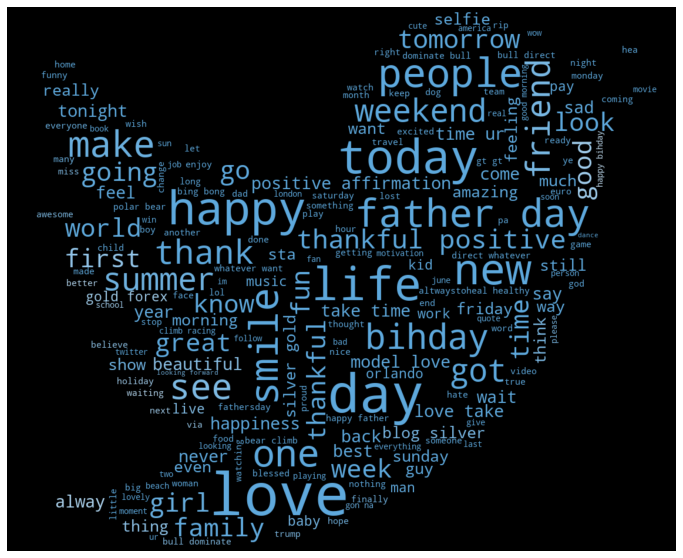

Wordcloud for sentiment 1


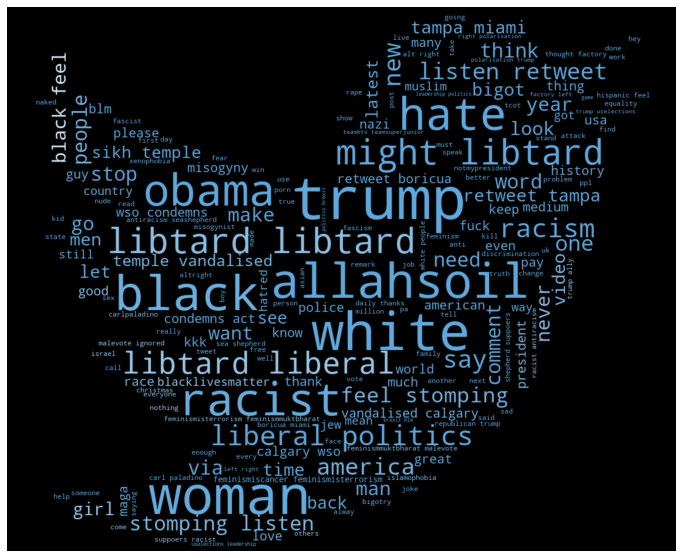

In [9]:
sentiment_possitive = ' '.join([word for word in tweetDataCleaned.loc[tweetDataCleaned['label']==0, 'cleaned']])
sentiment_negative = ' '.join([word for word in tweetDataCleaned.loc[tweetDataCleaned['label']==1, 'cleaned']])

sentiments = [sentiment_possitive, sentiment_negative]

def create_wordcloud(sentiments):
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(Mask)
    wordcloud = WordCloud(background_color='black',
                         max_font_size = 100, width=800, height=400, mask=Mask)
    
    for i in range(len(sentiments)):
        print('Wordcloud for sentiment', i)
        wordcloud.generate(sentiments[i])
        plt.figure(figsize=(15,10))
        plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation="hamming")
        plt.axis('off')
        plt.show()

create_wordcloud(sentiments)

# Checking class imbalance

Counter({0: 29720, 1: 2242})


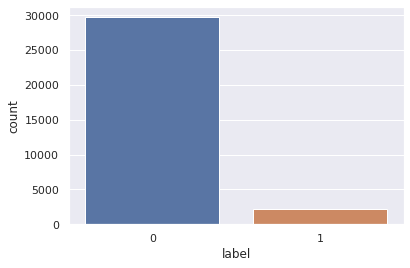

In [10]:
import collections

sentiment_counter = collections.Counter(tweetDataCleaned['label'])
print(sentiment_counter)

sns.set(style='darkgrid')
cp = sns.countplot(x='label', data=tweetDataCleaned)

[Text(0, 0.5, 'Percent'), Text(0.5, 0, 'sentiment')]

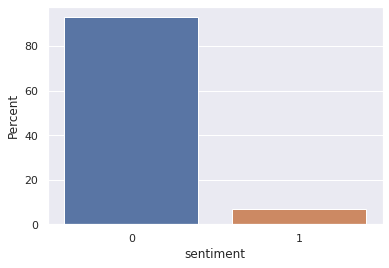

In [11]:
ax = sns.barplot(x='label',y='label', estimator=lambda x: len(x) / len(tweetDataCleaned) * 100, data=tweetDataCleaned)
ax.set(ylabel='Percent', xlabel='sentiment')

In [12]:
tweetDataCleaned['cleaned'] = tweetDataCleaned['cleaned'].apply(lambda x:" ".join([word for word in x.split() if len(word)>3]))
tweetDataCleaned['cleaned'] = tweetDataCleaned['cleaned'].apply(lambda x: word_tokenize(x))
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is s...,"[father, dysfunctional, selfish, drag, dysfunc..."
1,0,@user @user thanks for #lyft credit i can't us...,"[thanks, lyft, credit, cause, offer, wheelchai..."
2,0,bihday your majesty,"[bihday, majesty]"
3,0,#model i love u take with u all the time in ...,"[model, love, take, time]"
4,0,factsguide: society now #motivation,"[factsguide, society, motivation]"


In [13]:
ps = PorterStemmer()
tweetDataCleaned['cleaned'] = tweetDataCleaned['cleaned'].apply(lambda x: [ps.stem(word) for word in x])
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is s...,"[father, dysfunct, selfish, drag, dysfunct]"
1,0,@user @user thanks for #lyft credit i can't us...,"[thank, lyft, credit, caus, offer, wheelchair,..."
2,0,bihday your majesty,"[bihday, majesti]"
3,0,#model i love u take with u all the time in ...,"[model, love, take, time]"
4,0,factsguide: society now #motivation,"[factsguid, societi, motiv]"


In [14]:
tweetDataCleaned['cleaned'] = tweetDataCleaned['cleaned'].apply(lambda x: ' '.join([word for word in x]))
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag dysfunct
1,0,@user @user thanks for #lyft credit i can't us...,thank lyft credit caus offer wheelchair disapo...
2,0,bihday your majesty,bihday majesti
3,0,#model i love u take with u all the time in ...,model love take time
4,0,factsguide: society now #motivation,factsguid societi motiv


Wordcloud for sentiment 0


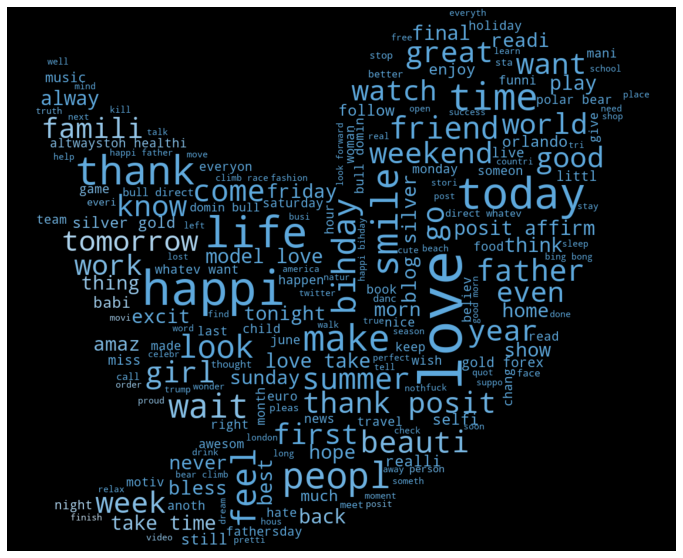

Wordcloud for sentiment 1


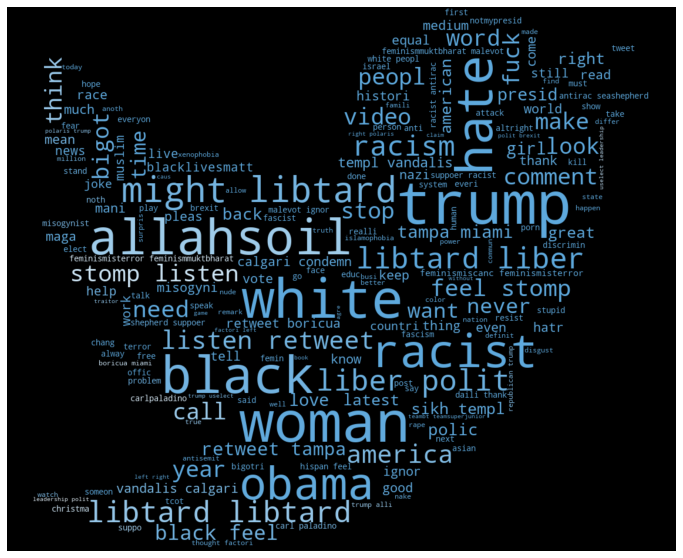

In [15]:
sentiment_possitive = ' '.join([word for word in tweetDataCleaned.loc[tweetDataCleaned['label']==0, 'cleaned']])
sentiment_negative = ' '.join([word for word in tweetDataCleaned.loc[tweetDataCleaned['label']==1, 'cleaned']])

sentiments = [sentiment_possitive, sentiment_negative]

create_wordcloud(sentiments)

# bag-of-word

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(tweetDataCleaned['cleaned'])

df_bow = pd.DataFrame(bow.todense())

#df_bow

# TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(tweetDataCleaned['cleaned'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

#df_tfidf

# Splitting our dataset into Training and Validation Set

In [18]:
from sklearn.model_selection import train_test_split

## Bag-of-words

In [36]:
train = tweetDataCleaned.iloc[:21308,0]
train_bow = bow[:21308]
train_bow.todense()
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,train,test_size=0.3,random_state=2)

## TF-IDF

In [39]:
train_tfidf_matrix = tfidf_matrix[:21308]
train_tfidf_matrix.todense()
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,train,test_size=0.3,random_state=17)

# Supervised Machine Learning

In [40]:
from sklearn.metrics import f1_score

## Logistic regression

### Bag-of-words features

In [41]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')

In [42]:
Log_Reg.fit(x_train_bow,y_train_bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
prediction_bow = Log_Reg.predict_proba(x_valid_bow)
prediction_bow

array([[0.9206962 , 0.0793038 ],
       [0.97697758, 0.02302242],
       [0.978071  , 0.021929  ],
       ...,
       [0.96678297, 0.03321703],
       [0.96984639, 0.03015361],
       [0.89406768, 0.10593232]])

In [44]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_bow[:,1]>=0.3

# converting the results to integer type
prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_bow = f1_score(y_valid_bow, prediction_int)

log_bow

0.5418227215980025

### TF_IDF features

In [45]:
Log_Reg.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)
prediction_tfidf

array([[0.98610333, 0.01389667],
       [0.95953214, 0.04046786],
       [0.93437483, 0.06562517],
       ...,
       [0.62538324, 0.37461676],
       [0.87688032, 0.12311968],
       [0.98542927, 0.01457073]])

In [46]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int)

log_tfidf

0.5702127659574467